# Notebook clasificación de imágenes usando Keras aplicación de Machine Learning (Redes neuronales)
**Palabras clave:
Análisis de Imágenes,
Extracción de características,
Machine Learning(Red neuronal multicapa),
ROC,
Accuracy**

In [ ]:
import numpy as np #Biblioteca para crear arreglos.
import matplotlib.pyplot as plt #Biblioteca para plotear.
import cv2 #Biblioteca para análisis de imágenes.
import pandas as pd #Biblioteca para importar datos.
from astropy.io import fits #Biblioteca para adquirir datos desde archivos fits.
from google.colab import drive #Biblioteca para importar datos desde google drive.
from astropy.visualization import make_lupton_rgb #Biblioteca para convertir imágenes a RGB desde archivos fits.
from google.colab.patches import cv2_imshow #Biblioteca con parche para mostrar imágenes desde cv2.
from skimage.feature import local_binary_pattern, greycomatrix, greycoprops #Biblioteca para extracción de características desde los niveles de gris en una matriz de co-ocurrencia.
from sklearn import preprocessing #Biblioteca para normalizar datos.
from sklearn.model_selection import train_test_split #Biblioteca para divir los datos de entrenamiento.
from keras.models import Sequential #Biblioteca para crear modelos secuenciales.
from keras.layers import Dense #Biblioteca para crear las capas de las redes neuronales (Una capa consta de una función de cálculo de tensor de entrada y tensor de salida).
from tensorflow import keras #Biblioteca para crear optimizadores.
from sklearn.metrics import roc_curve #Biblioteca para determinar datos de la curva característica operativa del receptor (ROC).
from sklearn.metrics import roc_auc_score #Biblioteca para determinar puntuaje de la clasificación de los datos.


## Astropy

**Obtención de los archivos fits.bz2 Nebulosa de Orión (M42)** https://dr10.sdss.org/fields/name?name=M42

In [ ]:
!wget https://dr10.sdss.org/sas/dr10/boss/photoObj/frames/301/6073/4/frame-u-006073-4-0063.fits.bz2
!wget https://dr10.sdss.org/sas/dr10/boss/photoObj/frames/301/6073/4/frame-i-006073-4-0063.fits.bz2
!wget https://dr10.sdss.org/sas/dr10/boss/photoObj/frames/301/6073/4/frame-g-006073-4-0063.fits.bz2


--2022-02-16 05:24:47--  https://dr10.sdss.org/sas/dr10/boss/photoObj/frames/301/6073/4/frame-u-006073-4-0063.fits.bz2
Resolving dr10.sdss.org (dr10.sdss.org)... 155.101.19.32
Connecting to dr10.sdss.org (dr10.sdss.org)|155.101.19.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3320613 (3.2M) [application/octet-stream]
Saving to: ‘frame-u-006073-4-0063.fits.bz2’

frame-u-006073-4-00 100%[===================>]   3.17M  1.83MB/s    in 1.7s    

2022-02-16 05:24:50 (1.83 MB/s) - ‘frame-u-006073-4-0063.fits.bz2’ saved [3320613/3320613]

--2022-02-16 05:24:50--  https://dr10.sdss.org/sas/dr10/boss/photoObj/frames/301/6073/4/frame-i-006073-4-0063.fits.bz2
Resolving dr10.sdss.org (dr10.sdss.org)... 155.101.19.32
Connecting to dr10.sdss.org (dr10.sdss.org)|155.101.19.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3044154 (2.9M) [application/octet-stream]
Saving to: ‘frame-i-006073-4-0063.fits.bz2’

frame-i-006073-4-00 100%[============

**Ahora se descromprime el archivo fits.bz2 en la ruta**

In [ ]:
!bunzip2 /content/frame-u-006073-4-0063.fits.bz2
!bunzip2 /content/frame-i-006073-4-0063.fits.bz2
!bunzip2 /content/frame-g-006073-4-0063.fits.bz2

**Con ayuda de la biblioteca Astropy realizamos la adquisición de información en los archivos fits.**
**(Para mayor información acerca de la estructura de los archivos fits visitar** https://www.stsci.edu/itt/review/dhb_2011/Intro/intro_ch23.html, **con ayuda de la linea M42u.info() se logará observar la composición de dicho archivo).**

*  M42i -> R
*  M42g -> G
*  M42u -> B

**Imagen a color (RGB) es el formato de la imagen que deseamos adquirir.**


In [ ]:
M42u = fits.open('/content/frame-u-006073-4-0063.fits')
M42i = fits.open('/content/frame-i-006073-4-0063.fits')
M42g = fits.open('/content/frame-g-006073-4-0063.fits')

**La información primaria se encuentra en la posición inicial [0], la cúal es almacenada en Mi,Mg,Mu respectivamente.**

In [ ]:
Mg = M42g[0].data
Mi = M42i[0].data
Mu = M42u[0].data

## Análisis de Imágenes

**Con ayuda de la biblioteca make_lupton_rgb adquirimos la imagen RGB con un estiramiento lineal de 1.5 y un aclaramiento 10**

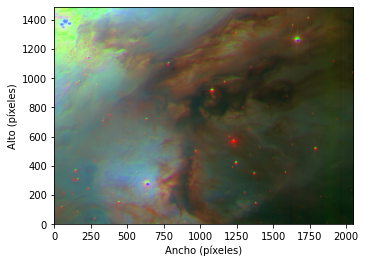

In [ ]:
rgb_default = make_lupton_rgb(Mi,Mg,Mu, stretch=1.5,Q=10)
 
plt.imshow(rgb_default,origin='lower')
plt.xlabel('Ancho (píxeles)')
plt.ylabel('Alto (píxeles)')
plt.savefig('rgbM42.png')

**Al implementar la biblioteca cv2 ahora se puede convertir la imagen RGB a escala de grises.**

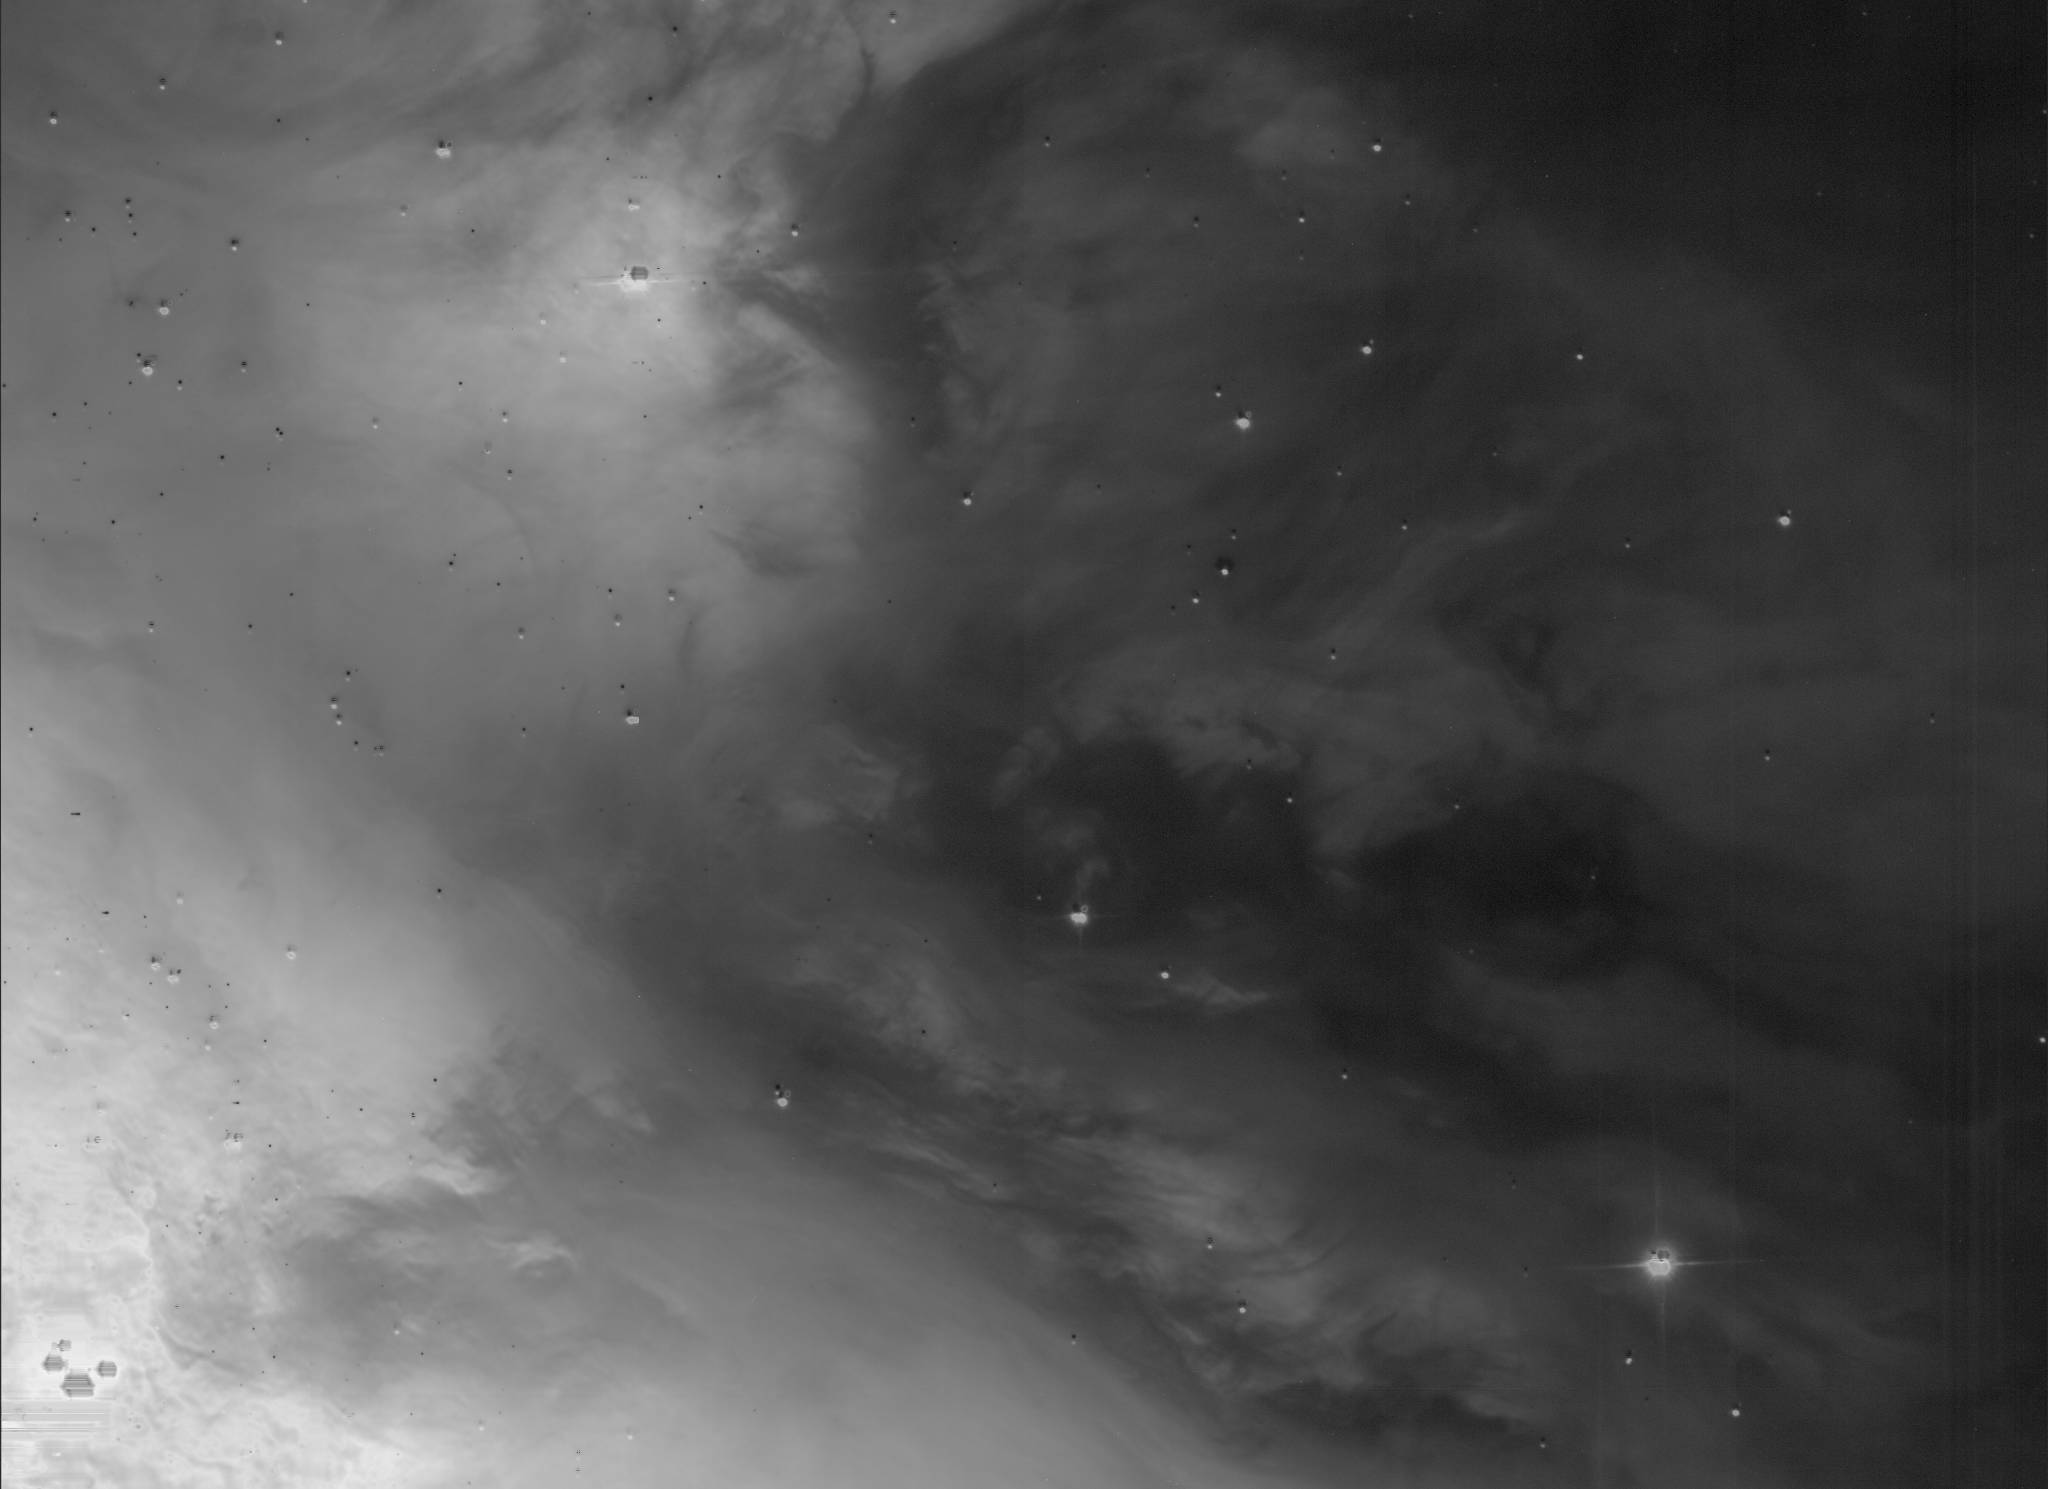

Text(0, 0.5, 'Alto (píxeles)')

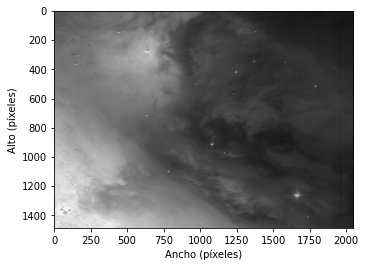

In [ ]:
#imagen = cv2.imread('/content/rgbM42.png')
grayscale_image = cv2.cvtColor(rgb_default, cv2.COLOR_BGR2GRAY)
#plt.imshow(img_gris)
cv2.imwrite('/content/M42_gray.png', grayscale_image) 
cv2_imshow(grayscale_image)
#cv2_imshow.xlabel('Ancho (píxeles)')
#cv2_imshow.ylabel('Alto (píxeles)')
plt.imshow(grayscale_image,cmap=plt.get_cmap("gray"))
plt.xlabel('Ancho (píxeles)')
plt.ylabel('Alto (píxeles)')



**Este es un ejemplo de la ventana de 25 x 25 que se adquiere de la imagen original en este caso M42.**

Text(0, 0.5, 'Alto (píxeles)')

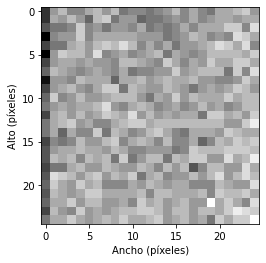

In [ ]:
window = grayscale_image[1:1+25, 1:1+25]
plt.imshow(window, cmap=plt.get_cmap("gray"))
plt.xlabel('Ancho (píxeles)')
plt.ylabel('Alto (píxeles)')

## Extracción de Características

**Aquí aplicamos extracción de características a partir de una imagen a escala de grises. para se obtienen N muestreos, los cuales contienen una ventana de 25x25 píxeles, a esta ventana le aplicamos extracción de características de primer orden:**
\begin{equation}
Min: Min = \textrm{argmin } P(i)
\end{equation}
\begin{equation}
Max: Max = \textrm{argmax } P(i)
\end{equation}
\begin{equation}
Media: \mu = \frac{1}{N} \sum_{i=1}^N i*P(i)
\end{equation}
\begin{equation}
Varianza: \sigma^2 = \sum_{i=1}^N (i-\mu)^2*P(i)
\end{equation}
**Con la ayuda de la biblioteca greycomatrix y greycoprops, adquirimos las características de la matriz de co-ocurrencia:**
\begin{equation}
Contraste: \sum_{i=1}^N \sum_{i=1}^M p(i,j)^2*(p(i,j))
\end{equation}
\begin{equation}
Disimilitud:  -\sum_{i=1}^N \sum_{i=1}^M p(i,j)\mid i-j\mid
\end{equation}
\begin{equation}
Homogeneidad: \sum_{i=1}^N \sum_{j=1}^M\frac{ p(i,j)}{1+(i-j)^2} 
\end{equation}
\begin{equation}
Energ\acute{ı}a: \sqrt{\sum_{i=1}^N \sum_{j=1}^M p^2(i,j)}
\end{equation}
\begin{equation}
Correlaci\acute{o}n: \frac{\sum_{i=1}^N \sum_{j=1}^M p(i,j)-\mu_{i}\mu_{j}}{\sigma_{i},\sigma_{j}} 
\end{equation}

**Estas características son almacenadas en un archivo csv**

In [ ]:
height, width= grayscale_image.shape
#array_Total = np.array
result = []
for i in range (0,height,25):
  for j in range (0,width,25):
    arrayData = np.arange(10,dtype = float)
    window = grayscale_image[i:i+25, j:j+25]
    arrayData[0] = window.min()
    arrayData[1] = window.max()
    arrayData[2] = window.mean()
    arrayData[3] = window.std()
    # Finding GLMC features from co-occurrance matrix
    gCoMat = greycomatrix(window.astype(int),[2],[0],256,symmetric=True, normed=True) #Co-occurrence matrix
    contrast = greycoprops(gCoMat, prop='contrast')
    dissimilarity = greycoprops(gCoMat, prop='dissimilarity')
    homogeneity = greycoprops(gCoMat, prop='homogeneity')
    energy = greycoprops(gCoMat, prop='energy')
    correlation = greycoprops(gCoMat, prop='correlation')
    arrayData[4] = contrast[0][0]
    arrayData[5] = dissimilarity[0][0]
    arrayData[6] = homogeneity[0][0]
    arrayData[7] = energy[0][0]
    arrayData[8] = correlation[0][0]
    arrayData[9] = 1
    #print('arrayData',arrayData)
    result.append(arrayData)
    #plt.imshow(window,origin='lower')
#print('res',result)
np.savetxt("M42_training_data.csv", result,header="Min,Max,Mean,Std,Contrast,Dissimilarity,Homogeneity,Energy,Correlation,Label", delimiter=",")

**El mismo procedimiento se realiza para la galaxia NGC 5866**
**Obtención de los archivos fits.bz2 de la galaxia NGC 5866** https://dr10.sdss.org/fields/name?name=NGC+5866

In [ ]:
!wget https://dr10.sdss.org/sas/dr10/boss/photoObj/frames/301/6122/1/frame-u-006122-1-0013.fits.bz2
!wget https://dr10.sdss.org/sas/dr10/boss/photoObj/frames/301/6122/1/frame-i-006122-1-0013.fits.bz2
!wget https://dr10.sdss.org/sas/dr10/boss/photoObj/frames/301/6122/1/frame-g-006122-1-0013.fits.bz2

--2022-02-16 05:27:28--  https://dr10.sdss.org/sas/dr10/boss/photoObj/frames/301/6122/1/frame-u-006122-1-0013.fits.bz2
Resolving dr10.sdss.org (dr10.sdss.org)... 155.101.19.32
Connecting to dr10.sdss.org (dr10.sdss.org)|155.101.19.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3146564 (3.0M) [application/octet-stream]
Saving to: ‘frame-u-006122-1-0013.fits.bz2’

frame-u-006122-1-00 100%[===================>]   3.00M  1.88MB/s    in 1.6s    

2022-02-16 05:27:30 (1.88 MB/s) - ‘frame-u-006122-1-0013.fits.bz2’ saved [3146564/3146564]

--2022-02-16 05:27:30--  https://dr10.sdss.org/sas/dr10/boss/photoObj/frames/301/6122/1/frame-i-006122-1-0013.fits.bz2
Resolving dr10.sdss.org (dr10.sdss.org)... 155.101.19.32
Connecting to dr10.sdss.org (dr10.sdss.org)|155.101.19.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3601583 (3.4M) [application/octet-stream]
Saving to: ‘frame-i-006122-1-0013.fits.bz2’

frame-i-006122-1-00 100%[============

In [ ]:
!bunzip2 /content/frame-u-006122-1-0013.fits.bz2
!bunzip2 /content/frame-i-006122-1-0013.fits.bz2
!bunzip2 /content/frame-g-006122-1-0013.fits.bz2

bunzip2: Output file /content/frame-u-006122-1-0013.fits already exists.
bunzip2: Output file /content/frame-i-006122-1-0013.fits already exists.
bunzip2: Output file /content/frame-g-006122-1-0013.fits already exists.


In [ ]:
NGC_5866u = fits.open('/content/frame-u-006122-1-0013.fits')
NGC_5866i = fits.open('/content/frame-i-006122-1-0013.fits')
NGC_5866g = fits.open('/content/frame-g-006122-1-0013.fits')

In [ ]:
NGCg = NGC_5866g[0].data
NGCi = NGC_5866i[0].data
NGCu = NGC_5866u[0].data

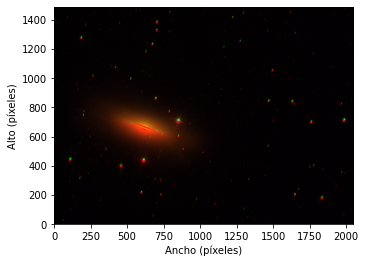

In [ ]:
rgb_default_NGC = make_lupton_rgb(NGCi,NGCg,NGCu,stretch=1.5,Q=10)

plt.imshow(rgb_default_NGC,origin='lower')
plt.xlabel('Ancho (píxeles)')
plt.ylabel('Alto (píxeles)')
plt.savefig('rgbNGC.png')

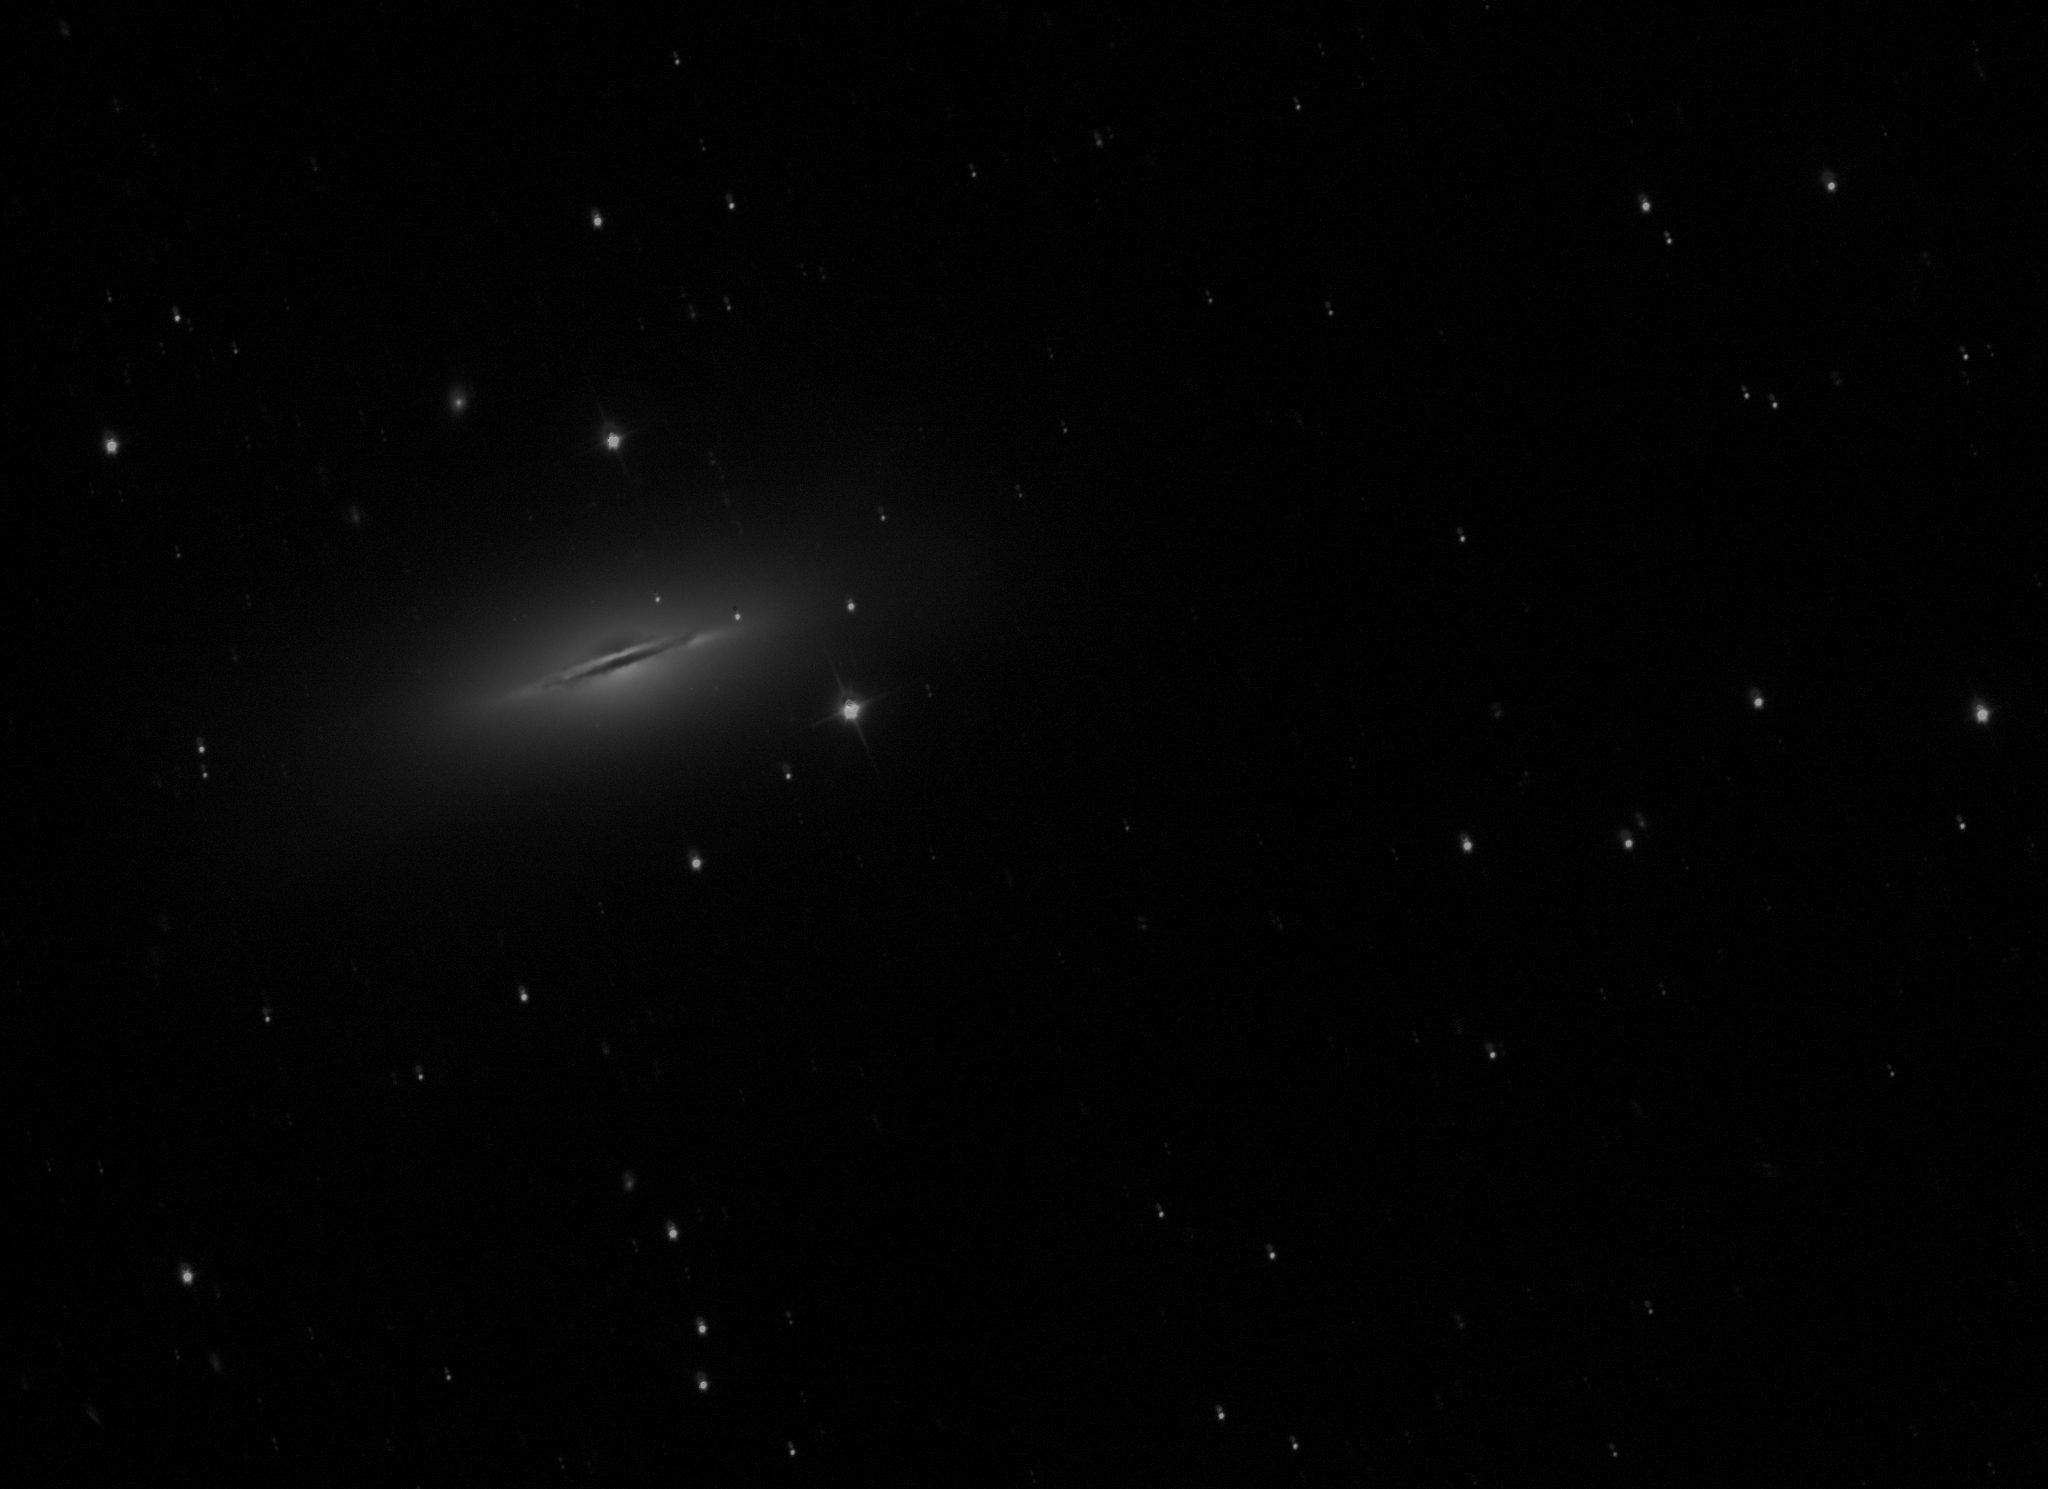

Text(0, 0.5, 'Alto (píxeles)')

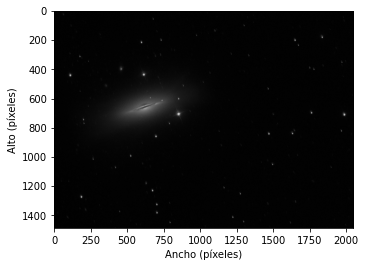

In [ ]:
#imagen = cv2.imread('/content/rgbM42.png')

grayscale_image_NGC_5866 = cv2.cvtColor(rgb_default_NGC, cv2.COLOR_BGR2GRAY)
#plt.imshow(img_gris)
cv2.imwrite('/content/NGC5866_gray.png', grayscale_image_NGC_5866) 
cv2_imshow(grayscale_image_NGC_5866)
#cv2_imshow.xlabel('Ancho (píxeles)')
#cv2_imshow.ylabel('Alto (píxeles)')
plt.imshow(grayscale_image_NGC_5866,cmap=plt.get_cmap("gray"))
plt.xlabel('Ancho (píxeles)')
plt.ylabel('Alto (píxeles)')

Text(0, 0.5, 'Alto (píxeles)')

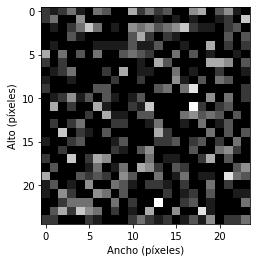

In [ ]:
window = grayscale_image_NGC_5866[1:1+25, 1:+25]
plt.imshow(window, cmap=plt.get_cmap("gray"))
plt.xlabel('Ancho (píxeles)')
plt.ylabel('Alto (píxeles)')

**La única diferencia en la adquisición de datos es adjuntar las características de NGC_5866 en M42 con la finalidad de compactar los datos en un sólo archivo csv**

In [ ]:
height, width= grayscale_image_NGC_5866.shape
#array_Total = np.array
#result = []
result = pd.read_csv('/content/M42_training_data.csv')
headers =[]
for col in result.columns:
  headers.append(col)
M42_size,M43_45 = result.shape
#headers=[' 	# Min','Max','Mean','Std','Contrast','Dissimilarity','Homogeneity','Energy','Correlation','Label']
for i in range (0,height,25):
  for j in range (0,width,25):
    window = grayscale_image_NGC_5866[i:i+25, j:j+25]
    gCoMat = greycomatrix(window.astype(int),[2],[0],256,symmetric=True, normed=True) #Co-occurrence matrix
    contrast_NGC = greycoprops(gCoMat, prop='contrast')
    dissimilarity_NGC = greycoprops(gCoMat, prop='dissimilarity')
    homogeneity_NGC = greycoprops(gCoMat, prop='homogeneity')
    energy_NGC = greycoprops(gCoMat, prop='energy')
    correlation_NGC = greycoprops(gCoMat, prop='correlation')
    data = {headers[0]: window.min(),
        headers[1]: window.max(),
        headers[2]: window.mean(),
        headers[3]: window.std(),
        headers[4]: contrast_NGC[0][0],
        headers[5]: dissimilarity_NGC[0][0],
        headers[6]: homogeneity_NGC[0][0],
        headers[7]: energy_NGC[0][0],
        headers[8]: correlation_NGC[0][0],
        headers[9]: 0
        }
    df = pd.DataFrame(data,index=[M42_size], columns = headers)
    result = result.append(df)
    M42_size = M42_size +1
np.savetxt("NGC_5866_training_data.csv", result, delimiter=",")

## Machine Learning (Redes neuronales multicapa)

**Se define df para la adquisición total de datos para M42 y NGC_5866**

In [ ]:
df = pd.read_csv('/content/NGC_5866_training_data.csv')

In [ ]:
df

,3.500000000000000000e+01,8.600000000000000000e+01,7.899840000000000373e+01,7.822531395910150565e+00,7.093043478260869961e+01,3.386086956521740188e+00,3.869236410914160262e-01,1.693443377438345887e-01,-1.439379326019615130e-02,1.000000000000000000e+00
0,78.0,87.0,82.585600,1.552119,3.645217,1.478261,0.463712,0.189074,0.243493,1.0
1,80.0,90.0,84.771200,1.650349,4.379130,1.655652,0.420780,0.176159,0.165091,1.0
2,82.0,91.0,86.433600,1.596744,4.071304,1.573913,0.442997,0.180237,0.180629,1.0
3,83.0,95.0,89.072000,2.000704,3.714783,1.516522,0.446575,0.158809,0.509765,1.0
4,86.0,96.0,91.176000,1.581210,3.269565,1.370435,0.491253,0.192612,0.335329,1.0
...,...,...,...,...,...,...,...,...,...,...
9834,0.0,8.0,1.822857,2.124024,9.245342,2.307453,0.393836,0.268809,0.001637,0.0
9835,0.0,13.0,1.625714,2.247518,11.335404,2.360248,0.417841,0.288068,-0.094361,0.0
9836,0.0,10.0,1.908571,2.220086,9.903727,2.326087,0.386380,0.246479,-0.046020,0.0
9837,0.0,12.0,1.685714,2.198330,9.571429,2.155280,0.451915,0.302958,0.038644,0.0


In [ ]:
dataset = df.values

**Se adquieren los valores en formato numpy.ndarray**

In [ ]:
dataset

array([[ 7.80000000e+01,  8.70000000e+01,  8.25856000e+01, ...,
         1.89073955e-01,  2.43493238e-01,  1.00000000e+00],
       [ 8.00000000e+01,  9.00000000e+01,  8.47712000e+01, ...,
         1.76159405e-01,  1.65091440e-01,  1.00000000e+00],
       [ 8.20000000e+01,  9.10000000e+01,  8.64336000e+01, ...,
         1.80237189e-01,  1.80628732e-01,  1.00000000e+00],
       ...,
       [ 0.00000000e+00,  1.00000000e+01,  1.90857143e+00, ...,
         2.46479005e-01, -4.60195084e-02,  0.00000000e+00],
       [ 0.00000000e+00,  1.20000000e+01,  1.68571429e+00, ...,
         3.02958230e-01,  3.86439548e-02,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+01,  1.69875776e+00, ...,
         2.81451024e-01, -9.40014752e-02,  0.00000000e+00]])

**Se adquieren los datos en X como características requeridas para el entrenmiento de la red neuronal, mientra que en Y se definen las etiquetas 1 para M42 y 0 para NGC_5866**

In [ ]:
X = dataset[:,0:9]
Y = dataset[:,9]

:**Con ayuda de la biblioteca preprocessing se normalizan los datos entre 0 y 1**

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(X)

In [ ]:
X_scale

array([[0.359447  , 0.33898305, 0.35404715, ..., 0.4944264 , 0.46676813,
        0.37265089],
       [0.36866359, 0.35169492, 0.36356039, ..., 0.43358166, 0.42666172,
        0.30695966],
       [0.37788018, 0.3559322 , 0.3707963 , ..., 0.46506896, 0.43932536,
        0.31997803],
       ...,
       [0.        , 0.01271186, 0.00288521, ..., 0.38482978, 0.64504075,
        0.13007421],
       [0.        , 0.02118644, 0.00191518, ..., 0.47770801, 0.8204382 ,
        0.20101196],
       [0.        , 0.01271186, 0.00197196, ..., 0.41374165, 0.75364711,
        0.08987113]])

**Se dividen los datos en:**


*   **Datos de entrenamiento 70%**
*   **Datos para validación 15%**
*   **Datos para pruebas 15%**



In [ ]:
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, Y, test_size=0.3)

In [ ]:
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

In [ ]:
print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)

(6887, 9) (1476, 9) (1476, 9) (6887,) (1476,) (1476,)


**Con la ayuda de la biblioteca Sequential y Dense se define el modelo de la red neuronal multicapa. Las funciones de activación: 'relu','tanh' son recomendadas en las capas intermedias mientras que para la última capa 'sigmoid' es recomendada**.
**La capa inicial consta de un tamaño de 9 entradas.**


*   **La capa inicial consta de un tamaño de 9 entradas.**
*   **La primera y segunda capa consta de 32 neuronas.**
*   **La última capa consta de una única salida con la capacidad de predecir el valor de salida próximo a 0 o 1**




In [ ]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(9,)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid'),
])



*   **opt: Para implementar la mejor tasa de aprendizaje, se recomienda implementar adam (método del gradiente descendiente estocástico) con un valor de 0.1, 0.01 o 0.001, esto puede ser un comportamiento de prueba y error con la finalidad de encontrar la mejor tasa de aprendizaje.**
*   **Loss: Calcula la pérdida de entropía cruzada entre etiquetas verdaderas y etiquetas predichas. Utilice esta pérdida de entropía cruzada cuando solo haya dos clases de etiquetas (se supone que son 0 y 1). Para cada ejemplo, debería haber un único valor de punto flotante por predicción.**
*   **metrics: Exactitud es la métrica ocupada.**








In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.001)#default is 0.001, puede ser 0.01 o 0.1
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

**El modelo de entramiento se realiza con un tamaño de muestreo de 250 filas que conforman las características con base en el archivo csv (batch_size), éste valor se puede cambiar entre 50, 100, 250 o 500 con la finalidad de encontrar el mejor resultado (prueba y error).**

**Se realiza un entrenamiento con 100 epocas a iterar.**




In [ ]:
hist = model.fit(X_train, Y_train,
          batch_size=250, epochs=100,
          validation_data=(X_val, Y_val))

Epoch 1/100
28/28 [==============================] - 1s 10ms/step - loss: 0.6893 - accuracy: 0.4999 - val_loss: 0.6343 - val_accuracy: 0.5054
Epoch 2/100
28/28 [==============================] - 0s 3ms/step - loss: 0.5875 - accuracy: 0.6332 - val_loss: 0.5225 - val_accuracy: 0.9241
Epoch 3/100
28/28 [==============================] - 0s 4ms/step - loss: 0.4642 - accuracy: 0.9389 - val_loss: 0.3975 - val_accuracy: 0.9465
Epoch 4/100
28/28 [==============================] - 0s 3ms/step - loss: 0.3482 - accuracy: 0.9551 - val_loss: 0.2946 - val_accuracy: 0.9587
Epoch 5/100
28/28 [==============================] - 0s 4ms/step - loss: 0.2495 - accuracy: 0.9694 - val_loss: 0.2070 - val_accuracy: 0.9688
Epoch 6/100
28/28 [==============================] - 0s 3ms/step - loss: 0.1732 - accuracy: 0.9752 - val_loss: 0.1472 - val_accuracy: 0.9695
Epoch 7/100
28/28 [==============================] - 0s 4ms/step - loss: 0.1253 - accuracy: 0.9782 - val_loss: 0.1113 - val_accuracy: 0.9736
Epoch 8/100


**Se evalua el modelo de acuerdo a las 100 iteraciones y se obtiene la exactitud del modelo establecido**

In [ ]:
model.evaluate(X_test, Y_test)[1]

47/47 [==============================] - 0s 3ms/step - loss: 0.0107 - accuracy: 0.9959


0.9959349632263184

In [ ]:
predictions = model.predict(X_test)
predictions

array([[9.9727952e-01],
       [3.2347441e-04],
       [3.2494916e-07],
       ...,
       [4.8783136e-06],
       [2.3609090e-08],
       [9.9999362e-01]], dtype=float32)

In [ ]:
for i in range(10):
	print('%s => %d (expected %d)' % (X_test[i].tolist(), predictions[i], Y_test[i]))

[0.1889400921658986, 0.21610169491525424, 0.21498399205671728, 0.048128026522369916, 0.006208888394408028, 0.13669154228855723, 0.3196614311585855, 0.20569073002216684, 0.5474999026372184] => 0 (expected 1)
[0.0, 0.02542372881355932, 0.014238015930341071, 0.03828403719277919, 0.008126389308314623, 0.16417910447761194, 0.25338377255540256, 0.232910822370502, 0.20281760539642857] => 0 (expected 0)
[0.0, 0.029661016949152543, 0.003826385945642637, 0.03718965815035774, 0.005930742909560716, 0.12238805970149252, 0.4163509116462776, 0.6137905448064418, 0.39806643167924205] => 0 (expected 0)
[0.22119815668202764, 0.23728813559322035, 0.2366429681452873, 0.03224805342470233, 0.006147582858972294, 0.14092039800995027, 0.2778402475111038, 0.27426781475785456, 0.22902178269112802] => 0 (expected 1)
[0.3686635944700461, 0.4279661016949153, 0.4226246261662717, 0.0977858208673132, 0.002456762568202409, 0.08034825870646767, 0.4330613441532134, 0.19039351407317975, 0.9393223307219885] => 0 (expected 1

In [ ]:
Y_test
predictions


array([[9.9727952e-01],
       [3.2347441e-04],
       [3.2494916e-07],
       ...,
       [4.8783136e-06],
       [2.3609090e-08],
       [9.9999362e-01]], dtype=float32)

## Resultados

**Se obtiene el arreglo como predicción de modelo. y se itera con la finalidad de obtener la matriz de confusión.**

*   **Verdaderos positivos**
*   **Falsos positivos**
*   **Verdaderos negativos**
*   **Falsos negativos**






In [ ]:
Y_test = Y_test.astype(int)
result = np.arange(predictions.size,dtype = int)
for indexIterator in range (0, predictions.size):
  if predictions[indexIterator] >= .5:
    result[indexIterator] = 1
  else :
    result[indexIterator] = 0
truePositive = 0
falsePositive = 0
trueNegative = 0
falseNegative = 0
for indexIterator in range (0, result.size):
  if Y_test[indexIterator] == 1 and result[indexIterator] == 1:
    truePositive = truePositive + 1
  elif Y_test[indexIterator] == 1 and result[indexIterator] == 0:
    falsePositive = falsePositive + 1
  elif Y_test[indexIterator] == 0 and result[indexIterator] == 0:
    trueNegative = trueNegative + 1
  else:
    falseNegative = falseNegative + 1

print('Verdaderos positivos',truePositive)
print('Falsos positivos',falsePositive)
print('Verdaderos negativos',trueNegative)
print('Falsos negativos',falseNegative)

Verdaderos positivos 728
Falsos positivos 2
Verdaderos negativos 742
Falsos negativos 4


**Se realiza un plot para comparar la función de entrenamiento con la función de validación.**

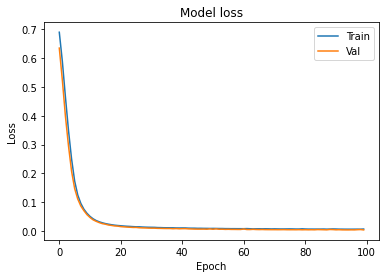

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

**Por último se define la curva ROC cuya objetivo es visualizar el comportamiento de los datos de la matriz de confusión.**

**Para ello es importante recordar que:**

**La elección se realiza mediante la comparación del área bajo la curva (AUC) de ambas pruebas. Esta área posee un valor comprendido entre 0,5 y 1, donde 1 representa un valor diagnóstico perfecto y 0,5 es una prueba sin capacidad discriminatoria diagnóstica. Es decir, si AUC para una prueba diagnóstica es 0,8 significa que existe un 80% de probabilidad de que el diagnóstico realizado a un enfermo sea más correcto que el de una persona sana escogida al azar. Por esto, siempre se elige la prueba diagnóstica que presente un mayor área bajo la curva.**

**A modo de guía para interpretar las curvas ROC se han establecido los siguientes intervalos para los valores de AUC:**

**[0.5]: Es como lanzar una moneda.**

**[0.5, 0.6): Test malo.**

**[0.6, 0.75): Test regular.**

**[0.75, 0.9): Test bueno.**

**[0.9, 0.97): Test muy bueno.**

**[0.97, 1): Test excelente.**

https://es.wikipedia.org/wiki/Curva_ROC

In [ ]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('Razón de falsos positivos')
    plt.ylabel('Razón de verdaderos positivos')
    plt.title('Característica operativa del receptor curva ROC')
    plt.legend()
    plt.show()

In [ ]:
probs = model.predict(X_test)
#probs = probs[:, 1]

In [ ]:
auc = roc_auc_score(Y_test, probs)
print('AUC: %.2f' % auc)

AUC: 1.00


In [ ]:
fpr, tpr, thresholds = roc_curve(Y_test, probs)

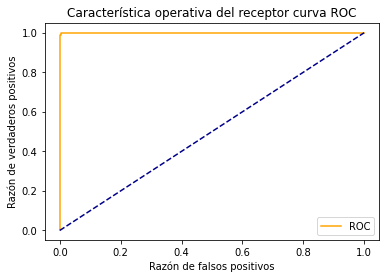

In [ ]:
plot_roc_curve(fpr, tpr)